In [40]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import pickle

external_path=''

In [2]:
concepts=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [42]:
class LinearClassifier(torch.nn.Module):
    def __init__(self, in_dimension: int):
        super().__init__()
        self.in_dimension=in_dimension
        self.linear=torch.nn.Linear(in_dimension,1)
        self.sigmoid=torch.nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.sigmoid(self.linear(x))

In [4]:
def get_dataset(positive_concept,negative_concept,layer):
    for k in range(1,11):
        if k==1:
            positive_concept_activations=torch.load(f'{external_path}\\concept_token_activations\\{positive_concept}\\layer{layer}_{k}.pt').squeeze(1)
        else:
            activations=torch.load(f'{external_path}\\concept_token_activations\\{positive_concept}\\layer{layer}_{k}.pt').squeeze(1)
            positive_concept_activations=torch.cat([positive_concept_activations,activations])
    
    for k in range(1,11):
        if k==1:
            negative_concept_activations=torch.load(f'{external_path}\\concept_token_activations\\{negative_concept}\\layer{layer}_{k}.pt').squeeze(1)
        else:
            activations=torch.load(f'{external_path}\\concept_token_activations\\{negative_concept}\\layer{layer}_{k}.pt').squeeze(1)
            negative_concept_activations=torch.cat([negative_concept_activations,activations])

    dataset=torch.cat([positive_concept_activations,negative_concept_activations])
    labels=torch.cat([torch.ones(positive_concept_activations.shape[0]),torch.zeros(negative_concept_activations.shape[0])])

    return dataset,labels

In [5]:
def get_cav(positive_concept,negative_concept,layer,lr=1e-3,batch_size=32,epochs=50):
    dataset,labels=get_dataset(positive_concept,negative_concept,layer)

    model=LinearClassifier(dataset.shape[1])
    optimizer=torch.optim.Adam(model.parameters(), lr=lr)
    criterion=torch.nn.BCELoss()

    for epoch in range(epochs):
        epoch_loss=0
        epoch_cycles=dataset.shape[0]//batch_size
        if dataset.shape[0]%batch_size==0:
            epoch_cycles+=1
        for k in range(epoch_cycles):
            optimizer.zero_grad()
            if k==epoch_cycles-1:
                epoch_data=dataset[k*batch_size:]
                epoch_labels=labels[k*batch_size:]
            else:
                epoch_data=dataset[k*batch_size:(k+1)*batch_size]
                epoch_labels=labels[k*batch_size:(k+1)*batch_size]
            outputs=model(epoch_data).T.squeeze(0)
            loss=criterion(outputs,epoch_labels)
            loss.backward()
            optimizer.step()
            epoch_loss+=loss.item()*len(epoch_labels)
        epoch_loss/=dataset.shape[0]
    cav=model.linear.weight[0].detach()
    return cav/torch.norm(cav),epoch_loss

In [77]:
pbar=tqdm(range(13))
for layer in pbar:
    if not(os.path.exists(f'{external_path}\\concept_activation_vectors\\{layer}')):
        os.mkdir(f'{external_path}\\concept_activation_vectors\\{layer}')
    losses={}
    for positive_concept in concepts:
        for negative_concept in concepts:
            if positive_concept==negative_concept:
                continue
            pbar.set_description(f'Layer {layer}: {positive_concept}_{negative_concept}')
            cav,loss=get_cav(positive_concept,negative_concept,layer)
            torch.save(cav,f'{external_path}\\concept_activation_vectors\\{layer}\\{positive_concept}_{negative_concept}.pt')
            losses[f'{positive_concept}_{negative_concept}']=loss
    losses_file=open(f'{external_path}\\concept_activation_vectors\\{layer}\\losses','wb')
    pickle.dump(losses,losses_file)
    losses_file.close()

Layer 0: airplane_automobile:   0%|          | 0/1 [00:00<?, ?it/s]

Layer 0: truck_ship: 100%|██████████| 1/1 [15:41<00:00, 941.69s/it]


In [20]:
def get_cbv(positive_concept,negative_concept,layer,lr=1e-3,num_steps=10000):
    if not(os.path.exists(f'{external_path}\\concept_boundary_vectors\\{layer}\\losses')):
        losses={}
    else:
        losses_file=open(f'{external_path}\\concept_boundary_vectors\\{layer}\\losses','rb')
        losses=pickle.load(losses_file)
        losses_file.close

    normals=np.load(f'{external_path}\\boundary_info\\{layer}\\normals\\{positive_concept}_{negative_concept}.npy')
    normals=torch.tensor(normals).float()

    optimized_vector=torch.rand((normals.shape[1]))
    optimized_vector=(optimized_vector/torch.norm(optimized_vector)).requires_grad_()

    optimizer=torch.optim.SGD([optimized_vector],lr=lr)

    steps=0
    while steps<num_steps:
        epoch_loss=0
        for k in range(normals.shape[0]):
            optimizer.zero_grad()
            dot=torch.dot(optimized_vector,normals[k,:])/torch.norm(optimized_vector)
            loss=torch.abs(1-dot)
            loss.backward()
            optimizer.step()
            epoch_loss+=loss
            steps+=1
    torch.save(optimized_vector/torch.norm(optimized_vector),f'{external_path}\\concept_boundary_vectors\\{layer}\\{positive_concept}_{negative_concept}.pt')
    losses[f'{positive_concept}_{negative_concept}']=(epoch_loss/normals.shape[0]).item()
    losses_file=open(f'{external_path}\\concept_boundary_vectors\\{layer}\\losses','wb')
    pickle.dump(losses,losses_file)
    losses_file.close()

In [78]:
pbar=tqdm(range(13))
for layer in pbar:
    if not(os.path.exists(f'{external_path}\\concept_boundary_vectors\\{layer}')):
        os.makedirs(f'{external_path}\\concept_boundary_vectors\\{layer}')
    for positive_concept in concepts:
        for negative_concept in concepts:
            if positive_concept==negative_concept:
                continue
            pbar.set_description(f'Layer {layer}: {positive_concept}_{negative_concept}')
            get_cbv(positive_concept,negative_concept,layer)

Layer 0: truck_ship: 100%|██████████| 1/1 [05:39<00:00, 339.64s/it]


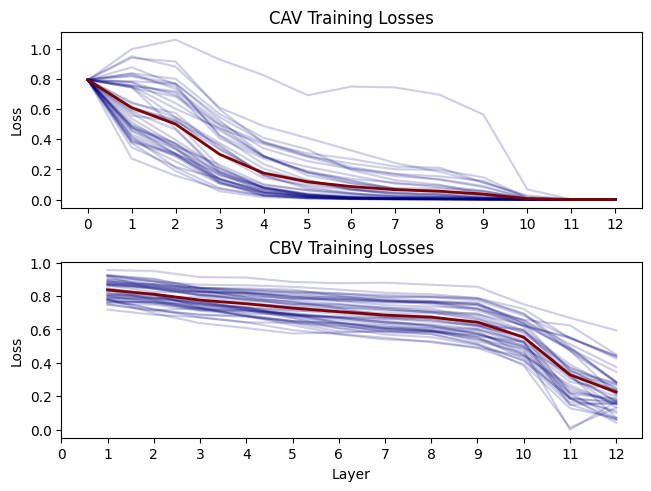

In [81]:
layers=range(13)
fig,axs=plt.subplots(nrows=2,ncols=1,layout='constrained')

aggregated_losses={}
average_losses=[]
for layer in layers:
    losses_file=open(f'{external_path}\\concept_activation_vectors\\{layer}\\losses','rb')
    losses=pickle.load(losses_file)
    losses_file.close()
    avg_loss=0
    for concept_concept,loss in losses.items():
        if concept_concept in aggregated_losses.keys():
            aggregated_losses[concept_concept].append(loss)
        else:
            aggregated_losses[concept_concept]=[loss]
        avg_loss+=loss
    average_losses.append(avg_loss/len(losses.items()))

colors=plt.cm.jet(np.linspace(0,1,2))

for k,(concept_concept,losses) in enumerate(aggregated_losses.items()):
    axs[0].plot(layers,losses,label=concept_concept,color=colors[0],alpha=0.1)
axs[0].plot(layers,average_losses,color=colors[1],linewidth=2)
axs[0].set_title('CAV Training Losses')
axs[0].set_xticks(layers)
axs[0].set_ylabel('Loss')

aggregated_losses={}
average_losses=[]
for layer in layers:
    losses_file=open(f'{external_path}\\concept_boundary_vectors\\{layer}\\losses','rb')
    losses=pickle.load(losses_file)
    losses_file.close()
    avg_loss=0
    for concept_concept,loss in losses.items():
        if concept_concept in aggregated_losses.keys():
            aggregated_losses[concept_concept].append(loss)
        else:
            aggregated_losses[concept_concept]=[loss]
        avg_loss+=loss
    average_losses.append(avg_loss/len(losses.items()))

for k,(concept_concept,losses) in enumerate(aggregated_losses.items()):
    axs[1].plot(range(13),losses,label=concept_concept,color=colors[0],alpha=0.1)
axs[1].plot(layers,average_losses,color=colors[1],linewidth=2)
axs[1].set_title('CBV Training Losses')
axs[1].set_xticks(layers)
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Layer')
plt.show()

In [70]:
def get_cbv_from_random_vectors(positive_concept,negative_concept,layer,lr=1e-3,num_steps=10000):
    if not(os.path.exists(f'{external_path}\\concept_boundary_vectors_from_random\\{layer}\\losses')):
        losses={}
    else:
        losses_file=open(f'{external_path}\\concept_boundary_vectors\\{layer}\\losses','rb')
        losses=pickle.load(losses_file)
        losses_file.close

    normals=np.load(f'{external_path}\\boundary_info\\{layer}\\normals\\{positive_concept}_{negative_concept}.npy')
    random_normals=torch.rand_like(torch.tensor(normals)).float()
    for k in range(random_normals.shape[0]):
        random_normals[k,:]/=torch.norm(random_normals[k,:])
    torch.save(random_normals,f'{external_path}\\concept_boundary_vectors_from_random\\{layer}\\{positive_concept}_{negative_concept}\\random_normals.pt')

    optimized_vector=torch.rand((random_normals.shape[1]))
    optimized_vector=(optimized_vector/torch.norm(optimized_vector)).requires_grad_()

    optimizer=torch.optim.SGD([optimized_vector],lr=lr)

    steps=0
    while steps<num_steps:
        epoch_loss=0
        for k in range(random_normals.shape[0]):
            optimizer.zero_grad()
            dot=torch.dot(optimized_vector,random_normals[k,:])/torch.norm(optimized_vector)
            loss=torch.abs(1-dot)
            loss.backward()
            optimizer.step()
            epoch_loss+=loss
            steps+=1
    torch.save(optimized_vector/torch.norm(optimized_vector),f'{external_path}\\concept_boundary_vectors_from_random\\{layer}\\{positive_concept}_{negative_concept}\\concept_vector.pt')
    losses[f'{positive_concept}_{negative_concept}']=(epoch_loss/normals.shape[0]).item()
    losses_file=open(f'{external_path}\\concept_boundary_vectors_from_random\\{layer}\\losses','wb')
    pickle.dump(losses,losses_file)
    losses_file.close()

    dots=np.zeros(random_normals.shape[0])
    for k in range(random_normals.shape[0]):
        dots[k]=(torch.dot(random_normals[k,:],optimized_vector)/torch.norm(optimized_vector)).item()
    np.save(f'{external_path}\\concept_boundary_vectors_from_random\\{layer}\\{positive_concept}_{negative_concept}\\dots.npy',dots)

In [82]:
pbar=tqdm(range(13))
for layer in pbar:
    if not(os.path.exists(f'{external_path}\\concept_boundary_vectors_from_random\\{layer}')):
        os.makedirs(f'{external_path}\\concept_boundary_vectors_from_random\\{layer}')
    for positive_concept in concepts:
        for negative_concept in concepts:
            if positive_concept==negative_concept:
                continue
            if not(os.path.exists(f'{external_path}\\concept_boundary_vectors_from_random\\{layer}\\{positive_concept}_{negative_concept}')):
                os.makedirs(f'{external_path}\\concept_boundary_vectors_from_random\\{layer}\\{positive_concept}_{negative_concept}')
            pbar.set_description(f'Layer {layer}: {positive_concept}_{negative_concept}')
            get_cbv_from_random_vectors(positive_concept,negative_concept,layer)

Layer 0: truck_ship: 100%|██████████| 1/1 [09:04<00:00, 544.39s/it]
